# Author: Nabil Ibtehaz (https://github.com/nibtehaz)


In [25]:
from ecg_qc.ecg_qc import EcgQc
from MAE1DCorrelated import MaskedAutoencoderViT1DCorrelated
from MAEBank import MAEBank
from refiner_unet import  UNet
import numpy as np
import torch
from torch import nn
from scipy.io import loadmat
from tqdm import tqdm
from typing import Callable, List, Optional, Tuple, Union
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from util.ecg_dataset import ECGPretrainDataset
import seaborn as sns
import os
from scipy import signal
import sys
sns.set()

In [4]:
mdl_bnk = MAEBank(['cpu'])
mdl_pth = 'experiments/expb3/'

for i in range(12):
    print(f'MAE {i+1} loaded')
    mdl_bnk.maes[i].load_state_dict(
        torch.load(
        f"{mdl_pth}saved_models/mae_channel_{i+1}_best.pth",
        map_location="cpu",
    )
)

Model config
MaskedAutoencoderViT1D(sig_len=2500, window_len=100, in_chans=1,embed_dim=768, depth=12, num_heads=8,decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=512,mlp_ratio=4.0, norm_layer=<class 'torch.nn.modules.normalization.LayerNorm'>, norm_pix_loss=True)
Initializing MAE 1
Initializing MAE 2
Initializing MAE 3
Initializing MAE 4
Initializing MAE 5
Initializing MAE 6
Initializing MAE 7
Initializing MAE 8
Initializing MAE 9
Initializing MAE 10
Initializing MAE 11
Initializing MAE 12
MAE 1 loaded
MAE 2 loaded
MAE 3 loaded
MAE 4 loaded
MAE 5 loaded
MAE 6 loaded
MAE 7 loaded
MAE 8 loaded
MAE 9 loaded
MAE 10 loaded
MAE 11 loaded
MAE 12 loaded


In [ ]:
target_chnl = 1

In [5]:
unt1 = UNet(target_chnl)

unt1.load_state_dict(
        torch.load(
        f"{mdl_pth}saved_models/unet_channel_{target_chnl}.pth",
        map_location="cpu",
    )
)

<All keys matched successfully>

In [46]:
files = [fl for fl in next(os.walk('/data/nabil/ecg_repr/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1'))[2] if '.mat' in fl]

ecg_data = ['/data/nabil/ecg_repr/physionet.org/files/challenge-2021/1.0.3/training/st_petersburg_incart/g1/'+fl for fl in files]



In [47]:
sig = loadmat(ecg_data[0])['val'] * 1.0

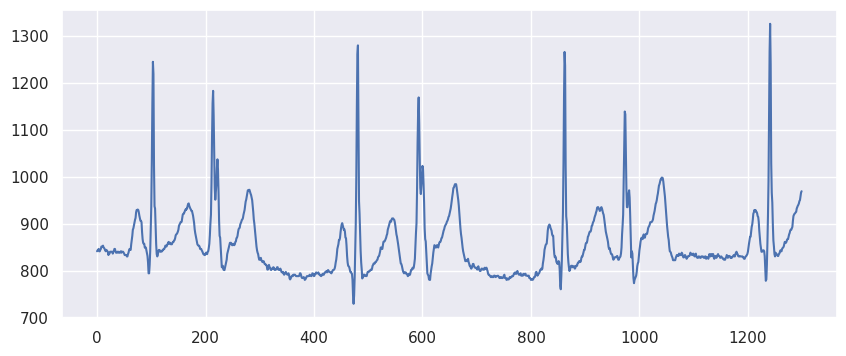

In [48]:
plt.figure(figsize=(10,4))
plt.plot(sig[0,:1300])

In [57]:
def resample_signal(sig, fold, fnew):

    cur_len = len(sig)
    rsmpld_sig = signal.resample(sig, int(cur_len*fnew/fold))    
    return rsmpld_sig


def resample_signal2(sig, out_sig_len, fold, fnew):

    cur_len = len(sig)
    rsmpld_sig = signal.resample(sig, int(cur_len*fnew/fold))
    padding = (len(rsmpld_sig) - out_sig_len)//2
    return rsmpld_sig[padding:padding+out_sig_len]


In [42]:

CHANNEL_NAMES = [' ','I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']

def compute_SNR(pred, gt):

    noise = pred - gt

    P_s = np.sum(np.dot(gt, gt))
    P_n = np.sum(np.dot(noise, noise))

    snr = 10 * np.log10(P_s/P_n)

    return snr

def filtering(signal,Fs=500,step2='movingAverage',step2Param=5,highPassFc=1,lowPassFc=30,butterworthOrder=12):
	"""
	Filters and preprocesses the signal.
		
		1 ) Substract the mean
		2 ) Moving average for high order noises
		3 ) High pass filter for drift suppression
		4 ) Low pass filter for high frequency suppression

	As presented in 
						E.M. Abu Anas, S.Y. Lee, M.K. Hasan
						Exploiting correlation of ECG with certain emd functions for discrimination of ventricular fibrillation
						Comput. Biol. Med., 41 (2) (2011), pp. 110-114
	
	Arguments:
		signal {numpy array} -- signal
		Fs {int} -- sampling frequency
	
	Keyword Arguments:
		step2 {str} -- which mode of filtering is used ? 'movingAverage' or 'gaussianFilter' (default: {'movingAverage'})
		step2Param {int} -- window length (default: {5})
		highPassFc {int} -- cut-off freq for high pass filter (default: {1})
		lowPassFc {int} -- cut-off freq for low pass filter (default: {30})
		butterworthOrder {int} -- order of butter worth filter (default: {12})
	
	Returns:
		[{numpy array}] -- the filtered and processed signal
	"""

	from scipy.signal import butter, filtfilt, lfilter

	# 1 ) Substract the mean

	miu = np.mean(signal)		# mean of the signal

	signal -= miu 


	# 2 ) Moving average for high order noises

	if(step2=='movingAverage'):

		signal2 = np.convolve(signal,np.ones(step2Param)/(step2Param*1.0))		# equivalent to moving average


	elif(step2=='gaussianFilter'):

		# to be implemented later 
		pass 

	# 3 ) High pass filter for drift suppression

	Fnyq = 0.5*Fs			# nyquist frequency 

	b, a = butter(1, highPassFc/ Fnyq , btype='highpass')		# definition of the high pass filter
	signal3 = lfilter(b, a, signal2)

	# 4 ) Low pass filter for high frequency suppression

	b,a = butter(12,lowPassFc/Fnyq)								# definition of the high pass filter
	signal4 = lfilter(b, a, signal3)
	
	return signal4



In [43]:
qc = EcgQc('rfc_norm_2s.pkl',
               sampling_frequency=500,
               normalized=True)


/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.24.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/nabil/ecg_repr/ecg_repr/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.24.2 when using version 1.2.2. This might

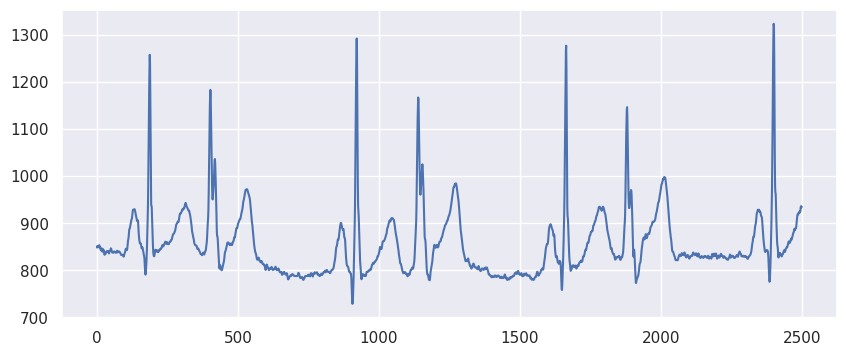

In [50]:
plt.figure(figsize=(10,4))
plt.plot(resample_signal(sig[0,:1300],2500,257,500))#signal.resample(sig[0,:1300], int(1300*500/257)))

In [84]:

def qc_fn(sgnl, sgnl_trgt, msk_ratio, core_chnl, target_chnl, pltt=False):

    pred_ensmeble = np.zeros(2500)
    cnt_ensmeble = np.zeros(2500)

    pred_refine_ensmeble = np.zeros(2500-4)
    cnt_refine_ensmeble = np.zeros(2500-4)


    #core_chnl = 1

    two_side_offset = 500
    offset_step = 50
    st_smpl = 500

    for st_ofset in (range(-two_side_offset,two_side_offset+1,offset_step)):
        
        sig = sgnl[st_smpl + st_ofset: st_smpl + st_ofset + 2500]
        ids_shuffle, ids_restore, ids_keep = mdl_bnk.propose_masking(1, mdl_bnk.num_patches, msk_ratio)
        
        x = torch.unsqueeze(torch.unsqueeze(torch.Tensor(sig), dim=0), dim=0)
        latent, mask = mdl_bnk.maes[core_chnl-1].forward_encoder(x, msk_ratio, ids_shuffle, ids_restore, ids_keep)

        pred = mdl_bnk.maes[target_chnl-1].forward_decoder(latent, ids_restore)    
        pred = mdl_bnk.maes[target_chnl-1].unpatchify(pred).detach().numpy().ravel()

        pred_refine = unt1(torch.unsqueeze(torch.unsqueeze(torch.Tensor(pred[2:-2]),dim=0),dim=0))
        pred_refine = pred_refine.detach().numpy().ravel() * 10
        


        if (st_ofset<0):
            pred_ensmeble[0:2500+st_ofset] += pred[-st_ofset:2500]
            pred_refine_ensmeble[0:2500+st_ofset-4] += pred_refine[-st_ofset:2500-4]
            cnt_ensmeble[0:2500+st_ofset] += 1
            cnt_refine_ensmeble[0:2500+st_ofset-2]

        elif(st_ofset==0):
            pred_ensmeble += pred
            pred_refine_ensmeble += pred_refine
            cnt_ensmeble += 1
            cnt_refine_ensmeble += 1

        else:
            pred_ensmeble[st_ofset:2500] += pred[0:2500-st_ofset]
            pred_refine_ensmeble[st_ofset+2:2500-4] += pred_refine[2:2500-4-st_ofset]
            cnt_ensmeble[st_ofset:2500] += 1
            cnt_refine_ensmeble[st_ofset+2:2500-4] += 1




    pred_ensmeble /= cnt_ensmeble
    pred_refine_ensmeble /= cnt_refine_ensmeble

    #pred_refine = unt1(torch.unsqueeze(torch.unsqueeze(torch.Tensor(pred_ensmeble[2:-2]),dim=0),dim=0))
    #pred_refine = pred_refine.detach().numpy() * 10
    #pred_refine = pred_refine.ravel()


    mask = mask[0]
    
    if pltt:
        plt.figure(figsize=(20,8))
        plt.subplot(2,1,1)
        plt.plot(sgnl_trgt, label="input signal", c='b')
        #plt.plot(gt.ravel(), label="ground truth", c='b')
        plt.plot(pred_ensmeble, label="reconstructed \n(boxes are masked)", c='r')
        plt.plot(pred_refine_ensmeble, label="unet refined", c='g')

        # plt.legend(loc=(1.00, 0.5))
        plt.title(f'SNR MAE: {round(compute_SNR(pred_ensmeble,sgnl_trgt),2)} dB UNet: {round(compute_SNR(pred_refine_ensmeble,sgnl_trgt[2:-2]),2)} dB')

        plt.legend()
                
        plt.tight_layout()

        #plt.figure(figsize=(15,5))
        plt.subplot(2,1,2)
        plt.plot(filtering(sgnl_trgt), label="input signal", c='b')
        plt.plot(filtering(pred_refine_ensmeble), label="unet refined", c='g')
        plt.title(f'SNR filtered {round(compute_SNR(filtering(pred_refine_ensmeble), filtering(sgnl_trgt[2:-2])),2)} dB')
        plt.legend()
        plt.tight_layout()

    snr_orig = np.round(compute_SNR(pred_refine_ensmeble,sgnl_trgt[2:-2]),3)
    snr_fltr = np.round(compute_SNR(filtering(pred_refine_ensmeble), filtering(sgnl_trgt[2:-2])),3)
    qc_original = qc.get_signal_quality(sgnl_trgt)
    qc_synth = qc.get_signal_quality(pred_refine_ensmeble)

    return snr_orig, snr_fltr, qc_original, qc_synth#, list(ids_shuffle.numpy()[0]), list(ids_restore.numpy()[0]), list(ids_keep.numpy()[0])

    #print(qc.get_signal_quality(sgnl),qc.get_signal_quality(pred_refine_ensmeble))


In [74]:
sig = loadmat(ecg_data[0])['val'] * 1.0


In [75]:
signal_input = sig[2,:]
signal_target = sig[0,:]

In [76]:
signal_input = resample_signal(signal_input, 257, 500)
signal_target = resample_signal(signal_target, 257, 500)

In [79]:
signal_input = (signal_input-np.mean(signal_input))/(np.std(signal_input)+1e-6)
signal_target = (signal_target-np.mean(signal_target))/(np.std(signal_target)+1e-6)

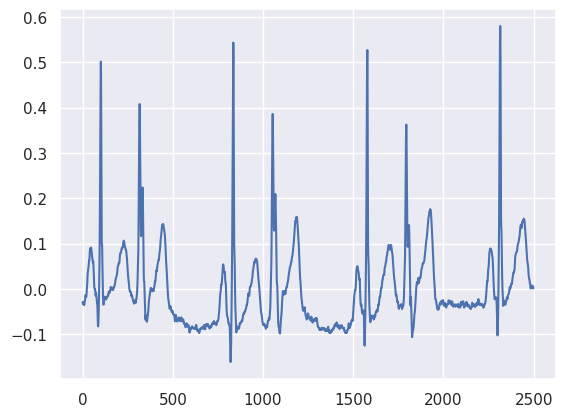

In [83]:
plt.plot(signal_target[100:2600])

In [80]:
np.mean(signal_target)

-3.3752358932462004e-16

(-7.843, -10.419, 0, 0)

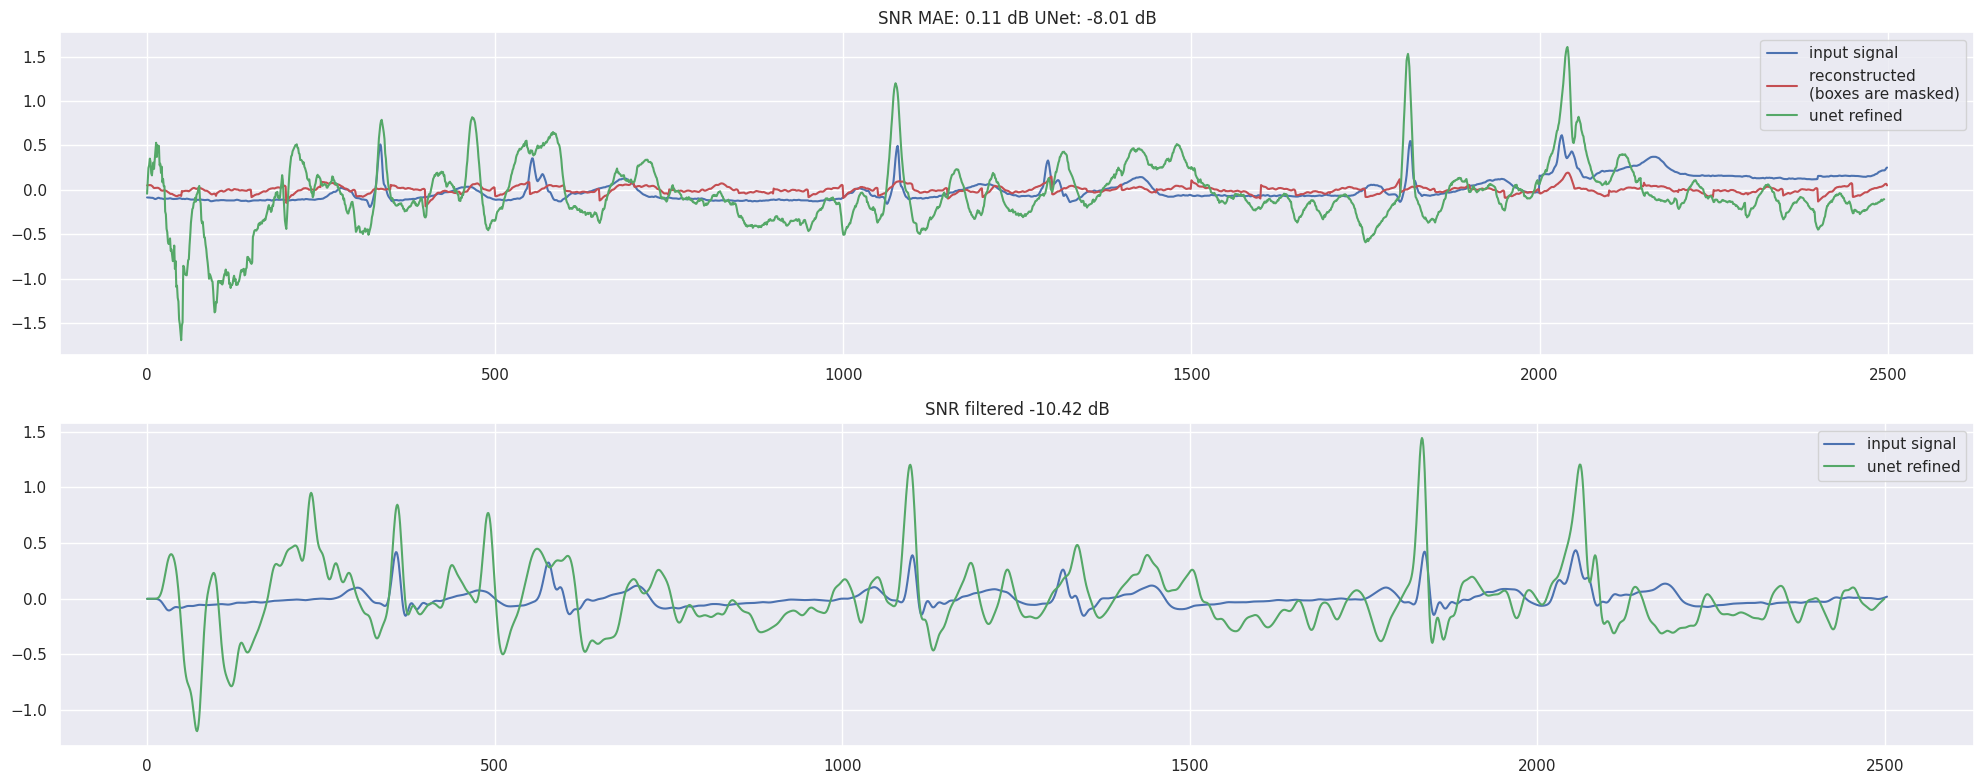

In [86]:
st_smpl = 100

qc_fn(signal_input[st_smpl:st_smpl+1000+2500], sgnl_trgt = signal_target[st_smpl + 500 : st_smpl + 500+2500 ], msk_ratio=0.75, core_chnl = 3, target_chnl = 1, pltt=True)